In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import logging
from functools import partial
from copy import deepcopy
from toolz import compose, valmap, keyfilter, identity
from itertools import combinations
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch

import sbi
import sbi.utils
import sbi.inference
import sbi.analysis
import sbibm

import swyft

import tmnre
import tmnre.metrics
import tmnre.benchmark
import tmnre.coverage.oned
from tmnre.nn.resnet import make_resenet_tail
from tmnre.marginalize import filter_marginals_by_dim

In [3]:
log = logging.getLogger()
log.setLevel(logging.INFO)
logging.getLogger('matplotlib').setLevel(logging.WARNING)

np.random.seed(28);
torch.manual_seed(28);

In [4]:
SAVE = False
DO_SBI = False

In [5]:
TASK_NAME = "eggbox"
NUM_OBS = 1
DIM = 10
N_SIMULATIONS = [1_000, 10_000, 100_000]
N_POSTERIOR_SAMPLES = 25_000
DEVICE = torch.device('cuda:1')
SIMKEY = 'mu'

task = sbibm.get_task(
    TASK_NAME,
    dim=DIM,
)

theta0 = task.get_true_parameters(NUM_OBS).squeeze()
obs0 = task.get_observation(NUM_OBS).squeeze()
print(theta0)
print(obs0)

tensor([0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500,
        0.2500])
tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000])


# Estimate Posterior Setup

### GOAL: Compare NRE_B to swyft, see that posterior is inaccurate unless you marginalize.

In [6]:
def swyftify_simulator(fn, x):
    xt = torch.from_numpy(x).float()
    y = fn(xt).squeeze().numpy()
    return {SIMKEY: y}

prior_transform = identity

forward = partial(swyftify_simulator, task.get_simulator())
simulator = swyft.Simulator(
    forward,
    sim_shapes = {SIMKEY: (task.dim_data,)}
)
store = swyft.MemoryStore(task.dim_parameters, simulator = simulator)

prior = swyft.Prior.from_uv(prior_transform, task.dim_parameters)
theta0_swyft = prior_transform(theta0.clone().squeeze().float().numpy())
obs0_swyft = {SIMKEY: obs0.clone().squeeze().float().numpy()}
print(obs0_swyft)

twod_marginals = list(combinations(range(task.dim_parameters), 2))
print(f"list of 2d marginals: {twod_marginals}")

{'mu': array([0.49999997, 0.49999997, 0.49999997, 0.49999997, 0.49999997,
       0.49999997, 0.49999997, 0.49999997, 0.49999997, 0.49999997],
      dtype=float32)}
list of 2d marginals: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (5, 8), (5, 9), (6, 7), (6, 8), (6, 9), (7, 8), (7, 9), (8, 9)]


In [7]:
myhps = True
if myhps:
    train_args = dict(
        batch_size=256,
        validation_size=0.10,
        early_stopping_patience=20,
        max_epochs=300,
        lr=1e-2,
        reduce_lr_factor=0.1,
        reduce_lr_patience=5,
        nworkers=3,
        # optimizer_fn=partial(torch.optim.SGD, momentum=0.9)
    )
    tail_args = dict(
        # hidden_features=128 + 32,
        hidden_features=50,
        num_blocks=2,
        online_z_score_obs=True,
        online_z_score_par=True,
        # dropout_probability=0.0,
        # activation = F.relu,
        use_batch_norm=True,
    )
    head_args = {
        # 'obs_shapes': {'mu': torch.Size([3])}, 
        # 'obs_transform': None, 
        'online_norm': False,
    }
    get_tail = make_resenet_tail
else:
    train_args = {}
    tail_args = {}
    head_args = {}
    make_resenet_tail = swyft.DefaultTail

### swyft

In [8]:
swyft_datasets = []
swyft_posts = []
swyft_samples = []
swyft_rejection_samples = []

if SAVE:
    for n in N_SIMULATIONS:
        dataset = swyft.Dataset(
            n,
            prior,
            store,
        )
        dataset.simulate()
        posterior = swyft.Posteriors(dataset)
        posterior.infer(
            [(i,) for i in range(task.dim_parameters)], 
            device = DEVICE,
            train_args = train_args,
            tail = get_tail,
            tail_args = tail_args,
            head_args = head_args,
        )
        posterior.infer(
            twod_marginals,
            device=DEVICE,
            train_args=train_args,
            tail=get_tail,
            tail_args=tail_args,
            head_args=head_args,
        )
        samples = posterior.sample(N_POSTERIOR_SAMPLES, obs0_swyft)
        rejection_samples = posterior.rejection_sample(
            N_POSTERIOR_SAMPLES, 
            obs0_swyft,
            excess_factor=10,
        )

        swyft_datasets.append(dataset)
        swyft_posts.append(posterior)
        swyft_samples.append(samples)
        swyft_rejection_samples.append(rejection_samples)
else:
    pass

### sbi

In [9]:
prior_min = torch.zeros(DIM)
prior_max = 1 * torch.ones(DIM)
sbi_prior = sbi.utils.torchutils.BoxUniform(
    low=torch.as_tensor(prior_min), 
    high=torch.as_tensor(prior_max)
)

sbi_posteriors = []
sbi_samples = []

if SAVE and DO_SBI:
    for n in N_SIMULATIONS:
        posterior = sbi.inference.base.infer(
            task.get_simulator(),
            sbi_prior,
            method='SNRE_A',
            num_simulations=n, 
            num_workers=4
        )

        samples = posterior.sample(
            (int(N_POSTERIOR_SAMPLES),), 
            x=torch.atleast_2d(obs0)
        )

        sbi_posteriors.append(posterior)
        sbi_samples.append(samples)
else:
    pass

In [10]:
# sequentially
seq_posteriors = []
seq_samples = []

seq_sim, seq_prior = sbi.inference.prepare_for_sbi(
    task.get_simulator(), 
    sbi_prior,
)

if SAVE and DO_SBI:
    for n in N_SIMULATIONS[:2]:
        num_rounds = 10
        n_per_round = n // 10
        
        posteriors = []
        inference = sbi.inference.SNRE_A(prior=seq_prior)
        proposal = seq_prior
        for r in range(10):
            theta, x = sbi.inference.simulate_for_sbi(seq_sim, proposal, num_simulations=n_per_round, num_workers=4)
            density_estimator = inference.append_simulations(theta, x, from_round=r).train()
            posterior = inference.build_posterior(density_estimator)
            posteriors.append(posterior)
            proposal = posterior.set_default_x(torch.atleast_2d(obs0))
        samples = posterior.sample(
            (int(N_POSTERIOR_SAMPLES),), 
            x=torch.atleast_2d(obs0)
        )
        seq_posteriors.append(posterior)
        seq_samples.append(samples)
else:
    pass

# Convert sbi samples to numpy

In [11]:
sbi_samples = [s.numpy() for s in sbi_samples]
seq_samples = [s.numpy() for s in seq_samples]

# SAVE / LOAD???

In [12]:
samples_path = f"eggbox-{DIM:02d}-samples.pickle"
seq_prefix = "seq/nsims-"
sbi_prefix = "sbi/nsims-"
swyft_prefix = "swyft/nsims-"
swyft_rejection_prefix = "rej-swyft/nsims-"
if SAVE and DO_SBI:
    with open(samples_path, "wb") as f:
        payload = {sbi_prefix + str(n): s for n, s in zip(N_SIMULATIONS, sbi_samples)}
        payload.update({seq_prefix + str(n): s for n, s in zip(N_SIMULATIONS, seq_samples)})
        payload.update({swyft_prefix + str(n): s for n, s in zip(N_SIMULATIONS, swyft_samples)})
        payload.update({swyft_rejection_prefix + str(n): s for n, s in zip(N_SIMULATIONS, swyft_rejection_samples)})
        pickle.dump(payload, f)
elif SAVE and not DO_SBI:
    with open(samples_path, "rb") as f:
        payload = pickle.load(f)
    sbi_samples = [payload[sbi_prefix + str(n)] for n in N_SIMULATIONS]
    seq_samples = [payload[seq_prefix + str(n)] for n in N_SIMULATIONS[:2]]
    with open(samples_path, "wb") as f:
        payload = {sbi_prefix + str(n): s for n, s in zip(N_SIMULATIONS, sbi_samples)}
        payload.update({seq_prefix + str(n): s for n, s in zip(N_SIMULATIONS, seq_samples)})
        payload.update({swyft_prefix + str(n): s for n, s in zip(N_SIMULATIONS, swyft_samples)})
        payload.update({swyft_rejection_prefix + str(n): s for n, s in zip(N_SIMULATIONS, swyft_rejection_samples)})
        pickle.dump(payload, f)
else:
    with open(samples_path, "rb") as f:
        payload = pickle.load(f)
    sbi_samples = [payload[sbi_prefix + str(n)] for n in N_SIMULATIONS]
    seq_samples = [payload[seq_prefix + str(n)] for n in N_SIMULATIONS[:2]]
    swyft_samples = [payload[swyft_prefix + str(n)] for n in N_SIMULATIONS]
    swyft_rejection_samples = [payload[swyft_rejection_prefix + str(n)] for n in N_SIMULATIONS]

# get marginals for sbi

In [13]:
sbi_marginals = [tmnre.marginalize.all_marginals(s) for s in sbi_samples]

# Take a look at sbi result

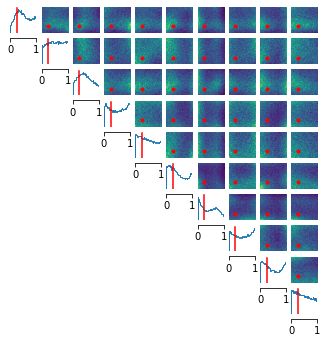

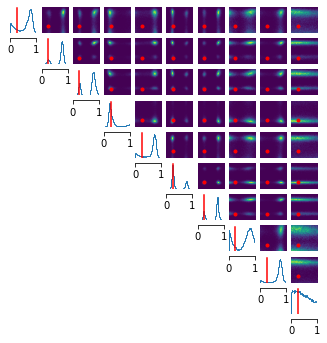

In [14]:
def plot(samples, limits: list):
    fig, axes = sbi.analysis.pairplot(
        samples, 
        limits=limits,
        figsize=(5.5,5.5),
        points=theta0,
        points_offdiag={'markersize': 6},
        points_colors='r'
    )
    return fig, axes

limits = torch.stack([prior_min, prior_max]).T.tolist()
for s in sbi_samples[:2]:
    fig, axes = plot(s, limits)
    for ax in axes.flatten():
        ax.set_xlabel("")
# fig.savefig("figures/eggbox-joint-nre-corner.pdf")

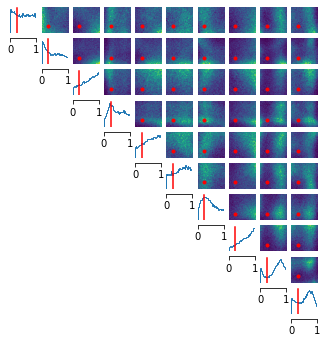

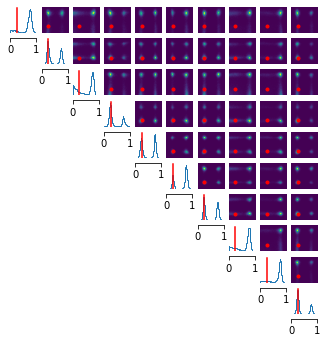

In [15]:
limits = torch.stack([prior_min, prior_max]).T.tolist()
for s in seq_samples:
    fig, axes = plot(s, limits)
    for ax in axes.flatten():
        ax.set_xlabel("")
# fig.savefig("figures/eggbox-joint-snre-corner.pdf")

### and swyft?

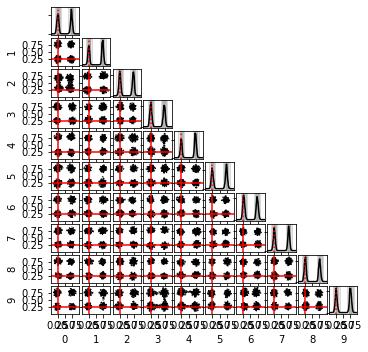

In [16]:
color = "k"
fig, axes = swyft.corner(
    payload['swyft/nsims-10000'], 
    range(task.dim_parameters), 
    color=color, 
    figsize = (5.5, 5.5), 
    truth=theta0,
)
# fig.savefig("figures/eggbox-swyft-corner.pdf")

# Credible Regions vs Parameter Index

Note that I found a source which helps with the estimate of the highst posterior density (HPD) credible interval for our situation. Namely,  
Chen, Ming-Hui, and Qi-Man Shao. 1999. “Monte Carlo Estimation of Bayesian Credible and HPD Intervals.” Journal of Computational and Graphical Statistics: A Joint Publication of American Statistical Association, Institute of Mathematical Statistics, Interface Foundation of North America 8 (1): 69–92.

We use a numerical integration method for now.

In [17]:
path = f"eggbox-{DIM}-ref.pickle"
if SAVE:
    ref_marginals = tmnre.benchmark.sbibm.load_ref_and_marginalize(task, NUM_OBS)
    ref_samples = task.get_reference_posterior_samples(NUM_OBS).numpy()
    with open(path, "wb") as f:
        pickle.dump((ref_marginals, ref_samples), f)
else:
    with open(path, "rb") as f:
        ref_marginals, ref_samples = pickle.load(f)

Text(0.5, 1.0, 'sbi')

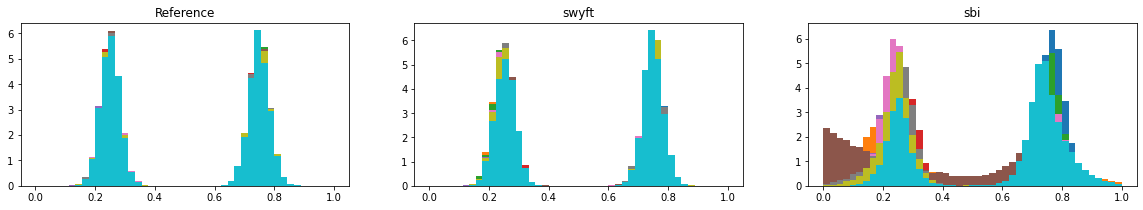

In [18]:
ref_marginals = tmnre.benchmark.sbibm.load_ref_and_marginalize(task, NUM_OBS)
ref_marginals_1d = filter_marginals_by_dim(ref_marginals, 1)

fig, axes = plt.subplots(ncols=3, figsize=(20, 3))
kwargs = dict(bins=45, range=(0, 1), density=True)

for key, rs1d in ref_marginals_1d.items():
    axes[0].hist(rs1d, **kwargs)

for ind in range(task.dim_parameters):
    s = swyft_samples[-1]
    sbi_s = sbi_samples[-1]
    axes[1].hist(s['params'][:, ind], weights=s['weights'][(ind,)], **kwargs)
    axes[2].hist(sbi_s[..., ind], **kwargs)

axes[0].set_title("Reference")
axes[1].set_title("swyft")
axes[2].set_title("sbi")

### How can we show this thing?

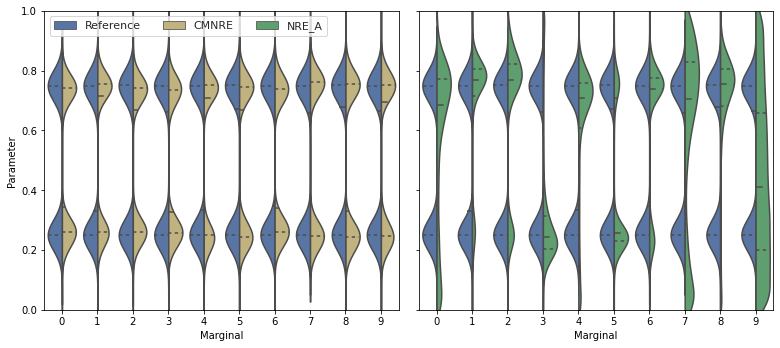

In [19]:
fig, axes = plt.subplots(ncols=2, figsize=(11, 5), sharey=True)

ref_marginals = tmnre.benchmark.sbibm.load_ref_and_marginalize(task, NUM_OBS)
swy_s = swyft_rejection_samples[-2]
sbi_s = sbi_marginals[-2]
# seq_s = sbi_marginals[-1]

my_pal = {"Reference": "b", "CMNRE": "y", "NRE_A": "g"}

swyft.utils.violin_plot(ref_marginals, swy_s, "CMNRE", ax=axes[0], palette=my_pal)
swyft.utils.violin_plot(ref_marginals, sbi_s, "NRE_A", ax=axes[1], palette=my_pal)

axes[1].set_ylabel("")

for ax in axes:
    ax.legend([],[], frameon=False)
    ax.set_ylim(0., 1.)

handles1, labels1 = axes[0].get_legend_handles_labels()
handles2, labels2 = axes[1].get_legend_handles_labels()

axes[0].legend(
    [*handles1, handles2[1]], 
    [*labels1, labels2[1]], 
    loc='upper left',
    ncol=3,
)
fig.tight_layout()
fig.savefig("figures/eggbox-violin.pdf")

In [20]:
# This is essentially an attempt at a "https://github.com/facebookresearch/hiplot" of the credible intervals.
# Not very robust.
if False:
    def get_ci(samples, credibility_level=0.95450, bins=55):
        samples_dim = filter_marginals_by_dim(samples, 1)
        return [tmnre.coverage.oned.get_credible_intervals(s, bins=bins, credibility_level=credibility_level) for s in samples_dim.values()]

    def get_swyft_ci(swyft_samples, credibility_level=0.95450, bins = 55):
        p = swyft_samples['params']
        w = filter_marginals_by_dim(swyft_samples['weights'], 1)
        return [tmnre.coverage.oned.get_credible_intervals(p[:, ind], w[(ind,)], bins, credibility_level=credibility_level) for ind in range(p.shape[-1])]

    def wandelt_plot(intervals, ref_intervals, ax=None):
        if ax is None:
            _, ax = plt.subplots()

        assert len(intervals) == len(ref_intervals)
        indices = np.arange(len(intervals))

        ax.plot(indices, [inter.flatten() for inter in intervals], 'b')

        # This is a bit fragile
        num_modes = len(ref_intervals[0][:, 0])
        for mode in range(num_modes):
            ax.fill_between(
                indices, 
                [inter[mode, 0] for inter in ref_intervals], [inter[mode, 1] for inter in ref_intervals], 
                alpha=0.5,
                color='orange',
            )
        return ax

    ref_intervals = get_ci(ref_marginals)
    swyft_intervals = [get_swyft_ci(ns) for ns in swyft_samples]
    sbi_intervals = [get_ci(bs) for bs in sbi_marginals]

    nrows = 2
    fig, axes = plt.subplots(nrows=nrows, ncols=len(swyft_samples), figsize=(20, 5))
    axes = axes.reshape(nrows, len(swyft_samples))
    for i, (swy_i, sbi_i) in enumerate(zip(swyft_intervals, sbi_intervals)):
        wandelt_plot(swy_i, ref_intervals, axes[0, i])
        wandelt_plot(sbi_i, ref_intervals, axes[1, i])
        axes[0, i].set_title(f"Round {i}")
    axes[0, 0].set_ylabel("swyft")
    axes[1, 0].set_ylabel("sbi")
    fig.tight_layout()

# kld vs budget

In [21]:
def get_summary_kld(samples, ref_samples, limits=(0.0, 1.0), add_a_sample=False):
    task_limits = np.ones((DIM, 2)) * limits
    doit = partial(
        tmnre.metrics.kl.kl_summary_swyft,
        ref_samples=ref_samples,
        task_limits=task_limits,
        dim=1,
        add_a_sample=add_a_sample,
    )
    return [sum(doit(swyft_samples=s).values()) for s in samples]

swyft_klds = get_summary_kld(swyft_samples, ref_samples)
sbi_klds = [
    sum(tmnre.metrics.kl.kls(sbi_sample, ref_samples, limits=(0.0, 1.0) * np.ones((DIM, 2)), bins=50, add_a_sample=True, dim=1).values())
    for sbi_sample in sbi_samples
]

/home/ben/sci/tmnre/.tmnre_env/lib/python3.9/site-packages/numpy/core/_asarray.py:171: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return array(a, dtype, copy=False, order=order, subok=True)
/home/ben/sci/tmnre/.tmnre_env/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=o

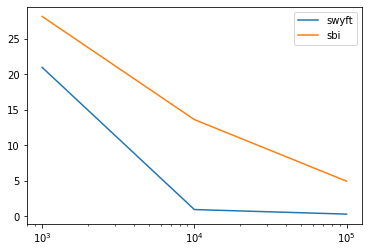

In [22]:
sns.reset_orig()
fig, ax = plt.subplots()
ax.plot(N_SIMULATIONS, swyft_klds, label="swyft")
ax.plot(N_SIMULATIONS, sbi_klds, label="sbi")
# ax.set_yscale("log")
ax.set_xscale("log")
ax.legend()

# c2st vs budget

In [23]:
reference_1d_marginals = filter_marginals_by_dim(ref_marginals, 1)
sbi_marginals = [tmnre.marginalize.all_marginals(sbi_s) for sbi_s in sbi_samples]
sbi_1d_marginals = [filter_marginals_by_dim(sbi_s, 1) for sbi_s in sbi_marginals]
swyft_1d_marginals = [filter_marginals_by_dim(swy_s, 1) for swy_s in swyft_rejection_samples]

get_10k = lambda x: np.random.permutation(x)[:10000, ...]

In [24]:
path = f"eggbox-{DIM}-c2sts.pickle"
if SAVE:
    swyft_c2sts = [
        tmnre.metrics.c2st.c2st_on_marginals(reference_1d_marginals, valmap(get_10k, swy_s), n_jobs=12)
        for swy_s in swyft_1d_marginals
    ]
    sbi_c2sts = [
        tmnre.metrics.c2st.c2st_on_marginals(reference_1d_marginals, valmap(get_10k, sbi_s), n_jobs=12)
        for sbi_s in sbi_1d_marginals
    ]
    with open(path, "wb") as f:
        pickle.dump((swyft_c2sts, sbi_c2sts), f)
else:
    with open(path, "rb") as f:
        swyft_c2sts, sbi_c2sts = pickle.load(f)

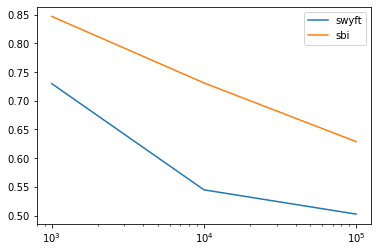

In [25]:
fig, ax = plt.subplots()
get_mean = lambda x: [i['1-dim mean'] for i in x]

ax.plot(N_SIMULATIONS, get_mean(swyft_c2sts), label="swyft")
ax.plot(N_SIMULATIONS, get_mean(sbi_c2sts), label="sbi")
# ax.set_yscale("log")
ax.set_xscale("log")
ax.legend()